# AR insert ligand workflow

In [1]:
import os
import shutil
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults
import nglview as nv
# from openbabel import openbabel
import MDAnalysis as mda
# import concurrent.futures
import numpy as np
import parmed as pmd

# import sys
# import plotly.express as px
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import plotly.figure_factory as ff
# import mdtraj as md



/home/s.emanuele/anaconda3/envs/STOCAZZO-311/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:160: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


### Functions

Creating all the folders required

In [2]:
def check_location(message, location, is_directory=False):
    from os.path import isdir, isfile
    if is_directory and isdir(location):
        print(f"{message}: {location} Exists")
    elif isfile(location):
        print(f"{message}: {location} Exists")
    else: print(f"{message}: {location} Not Found")


def create_folder(folder_path):
    try:
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' created successfully.")
    except OSError as e:
        print(f"Error creating folder '{folder_path}': {e}")


def copy_files(source_directory, destination_directory, file_names):
    try:
        for file_name in file_names:
            source_path = os.path.join(source_directory, file_name)
            destination_path = os.path.join(destination_directory, file_name)
            shutil.copy(source_path, destination_path)
            print(f"File '{file_name}' copied successfully.")
    except Exception as e:
        print(f"Error copying files: {e}")



Functions

In [3]:
# SHOW INDEX ON RDKIT IMAGE
# define the atom indices to be mapped from simulation data 
def mol_with_atom_index(mol): 
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

In [4]:
# READ FILE HEADER
def read_first_line(file_path):
    try:
        with open(file_path, 'r') as file:
            first_line = file.readline().strip()
            return first_line
    except Exception as e:
        return f"An error occurred: {e}"

In [5]:
# LAST LINE FOR SOL
def read_last_line(file_path):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
            last_line = lines[-1].strip()
            return last_line
    except Exception as e:
        return f"An error occurred: {e}"



In [6]:
def read_lines_in_range(file_path, start_line, end_line):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
            lines_in_range = lines[start_line - 1:end_line]
            cleaned_lines = [line.strip() for line in lines_in_range]
            return cleaned_lines
    except Exception as e:
        return [f"An error occurred: {e}"]

In [7]:
# REPLACE ITP LINE
def replace_line_match(file_path, search_string, replacement):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()

        with open(file_path, 'w') as file:
            for line in lines:
                if search_string in line:
                    line = line.replace(search_string, replacement)
                file.write(line)
        return "Replacement completed."
    except Exception as e:
        return f"An error occurred: {e}"

In [8]:
def remove_line_and_following(file_path, search_string, lines_after = 3):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()

        with open(file_path, 'w') as file:
            remove_next = 0
            for line in lines:
                if search_string not in line:
                    if remove_next > 0:
                        remove_next -= 1
                    else:
                        file.write(line)
                else:
                    remove_next = lines_after  # Set the number of lines to remove after the match

        return "Line and following lines removal completed."
    except Exception as e:
        return f"An error occurred: {e}"

In [9]:
# INSERT LIGAND LINES IN TOPOLOGY
def insert_line_at_number(file_path, line_to_insert, line_number):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()

        lines.insert(line_number - 1, line_to_insert + '\n')

        with open(file_path, 'w') as file:
            file.writelines(lines)
        return "Insertion completed."
    except Exception as e:
        return f"An error occurred: {e}"

In [10]:
def divide_replica_chunks(l, n):
    for i in range(0, len(l), n): 
        yield l[i:i + n]

In [11]:
def format_chunk(chunk):
    str_chunk = []
    for n in chunk:
        str_chunk.append(str(n))

    format_chunk = ','.join(str_chunk)
    return format_chunk

In [12]:
def set_working_directory(new_directory):
    try:
        os.chdir(new_directory)
        print(f"Working directory changed to: {os.getcwd()}")
    except OSError as e:
        print(f"Error changing working directory: {e}")

In [13]:
def get_box(replica, n_steps=-10000):
    # TODO to be addded in the previous one to use a for loop less
    box_size = np.loadtxt(f'./{replica}/npt.energy2.xvg', comments=['@', '#'], unpack=True)[1]
    ave_box = np.mean(box_size)
    reduced_ave_box = np.mean(box_size[n_steps:])
    return box_size, ave_box, reduced_ave_box


In [14]:
def get_gmx_energy(replica):
    gmx_energy_cmd = f'echo -e "11 12 13 15 17 48 49 0\n" | gmx energy -s ./{replica}/npt2.tpr -f ./{replica}/npt2.edr -o ./{replica}/npt.energy1.xvg'
    gmx_energy2_cmd = f'echo -e "19 22 23 24 25 0\n" | gmx energy -s ./{replica}/npt2.tpr -f ./{replica}/npt2.edr -o ./{replica}/npt.energy2.xvg'
    !{gmx_energy_cmd}
    !{gmx_energy2_cmd}


In [15]:
def get_gmx_energy_test_press(replica):
    gmx_energy_cmd = f'echo -e "11 12 13 15 17 48 49 0\n" | gmx energy -s ./{replica}/test_press.tpr -f ./{replica}/test_press.edr -o ./{replica}/test_press.xvg'
    !{gmx_energy_cmd}


In [16]:
def get_test_press(replica, n_steps=-10000):
    # TODO to be addded in the previous one to use a for loop less
    pressure = np.loadtxt(f'./{replica}/test_press.xvg', comments=['@', '#'], unpack=True)[5]
    ave_pressure = np.mean(pressure)
    reduced_ave_pressure = np.mean(pressure[n_steps:])
    return pressure, ave_pressure, reduced_ave_pressure


In [17]:
def make_box_editconf(replica, box_size):
    round(box_size, 5)
    gmx_editconf_cmd = f'gmx editconf -f ./{replica}/npt2.pbc.gro -o./{replica}/{replica}.new.gro -box {box_size} {box_size} {box_size}'
    !{gmx_editconf_cmd}

In [18]:
def make_boxes_editconf(replica, box_sizes_dict):
    gmx_editconf_cmd = f'gmx editconf -f ./{replica}/npt2.pbc.gro -o ./{replica}/{replica}.new.gro -box {box_sizes_dict[replica]} {box_sizes_dict[replica]} {box_sizes_dict[replica]}'    
    #print(gmx_editconf_cmd)
    !{gmx_editconf_cmd}

Packmol scripts

In [19]:
# WATER PACKMOL
def make_water_packmol_inp(input_file_path, output_file_path, replacements):
    try:
        with open(input_file_path, 'r') as input_file, open(output_file_path, 'w') as output_file:
            for line in input_file:
                for old_str, new_str in replacements.items():
                    line = line.replace(old_str, new_str)
                output_file.write(line)
        print("File parsing and writing completed successfully.")
    except Exception as e:
        print(f"Error parsing or writing file: {e}")


### Names,  definitions and settings

In [20]:
number_of_replicas = 20
ligand_name_prefix = 'Masofaniten'
ligand_chain_name = 'MFT'
protein_name_prefix = 'R2_R3_69aa'
working_directory = '/home/s.emanuele/AR/R2_R3_69aa_Masofaniten/'
protein_apo_folder = '/home/s.emanuele/AR/R2_R3_69aa_MD/'
protein_apo_pdb = f'{protein_apo_folder}{protein_name_prefix}.pdb'
smiles = 'CC(C)(C1=CC=C(C=C1)OCC2=NC(=NC=C2)NS(=O)(=O)C)C3=CC(=C(C(=C3)Cl)OCCCl)C#N'


set_working_directory(f'{working_directory}')
!ln -s /home/s.emanuele/AR/a99SBdisp.ff /home/s.emanuele/AR/R2_R3_69aa_Masofaniten/


# TODO in case of a rerun
make_pdb = True
insert_ligand = True
solvate = True
add_ions = True


gmx_gpu_mpi_path = 'mpirun -np ${OMPI_NP} /usr/bin/singularity run --nv --bind /data --bind ${HOME} ${HOME}/containers/gromacs_gpu.sif gmx_gpu "$@"'

# chunks of 4 ntomp 4 
# or
# chunks of 5 ntomp 3
mpi_threads = 4 # replicas will be divided by this and simulated in chunks
replica_chunks = 4 # How many directories will be run, should correspond to mpi_threads
ntomp = 4

list_replica_dir = list(range(0, number_of_replicas))
chunk_list_replica_dir = list(divide_replica_chunks(list_replica_dir, replica_chunks))

Working directory changed to: /home/s.emanuele/AR/R2_R3_69aa_Masofaniten
ln: failed to create symbolic link '/home/s.emanuele/AR/R2_R3_69aa_Masofaniten/a99SBdisp.ff': File exists


In [21]:

create_folder('./ligand_ff/')
create_folder('./equilibrate')
!ln -s /home/s.emanuele/AR/a99SBdisp.ff /home/s.emanuele/AR/R2_R3_69aa_Masofaniten/equilibrate
copy_files(f'{protein_apo_folder}', './equilibrate/', [f'{protein_name_prefix}.pdb'])
protein_apo_pdb = f'./equilibrate/{protein_name_prefix}.pdb'

# Those will be used with packmol
create_folder('./ligand_volume/')
create_folder('./ligand_volume/setup/')
create_folder('./REST/')
create_folder('./REST/structure/')

# Create replica folders
for replica in range(0, number_of_replicas):
    create_folder(f'./equilibrate/{replica}')


Error creating folder './ligand_ff/': [Errno 17] File exists: './ligand_ff/'
Error creating folder './equilibrate': [Errno 17] File exists: './equilibrate'
ln: failed to create symbolic link '/home/s.emanuele/AR/R2_R3_69aa_Masofaniten/equilibrate/a99SBdisp.ff': File exists
File 'R2_R3_69aa.pdb' copied successfully.
Error creating folder './ligand_volume/': [Errno 17] File exists: './ligand_volume/'
Error creating folder './ligand_volume/setup/': [Errno 17] File exists: './ligand_volume/setup/'
Error creating folder './REST/': [Errno 17] File exists: './REST/'
Error creating folder './REST/structure/': [Errno 17] File exists: './REST/structure/'
Error creating folder './equilibrate/0': [Errno 17] File exists: './equilibrate/0'
Error creating folder './equilibrate/1': [Errno 17] File exists: './equilibrate/1'
Error creating folder './equilibrate/2': [Errno 17] File exists: './equilibrate/2'
Error creating folder './equilibrate/3': [Errno 17] File exists: './equilibrate/3'
Error creating 

### Ligand insertion

SMILE import

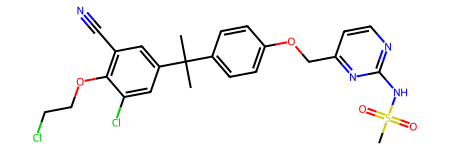

In [22]:
ligand_rdkit = Chem.MolFromSmiles(smiles)
ligand_rdkit

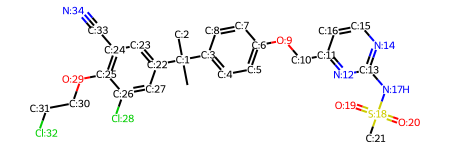

In [23]:
mol_with_atom_index(ligand_rdkit)

In [24]:

ligand_rdkit = Chem.AddHs(ligand_rdkit) # adding explicit Hs for 3D generation
cid = AllChem.EmbedMolecule(ligand_rdkit) # returns the id of the generated conformer, and -1 if no conformers were generated
print('Conformers:', cid)
AllChem.MMFFOptimizeMolecule(ligand_rdkit) # optimize molecule with MMFF94
if make_pdb is True:
    Chem.MolToPDBFile(ligand_rdkit, f'./{ligand_name_prefix}.pdb', flavor=2|8) # save to PDB-file
    Chem.MolToPDBFile(ligand_rdkit, f'./ligand_ff/{ligand_name_prefix}.pdb', flavor=2|8) # save to PDB-file
ligand_pdb = nv.show_file(f'./{ligand_name_prefix}.pdb')
ligand_pdb

Conformers: 0


NGLWidget()

Create the ligand GAFF FF using AmberTools by following this tutorial
https://ambermd.org/tutorials/basic/tutorial4b/index.php

In [25]:
# TODO check charges

In [26]:
# Renaming the chain
search_string = 'UNL'
replacement = f'{ligand_chain_name}'
print(replace_line_match(f'./{ligand_name_prefix}.pdb', search_string, replacement))
print(replace_line_match(f'./ligand_ff/{ligand_name_prefix}.pdb', search_string, replacement))
print(f"Header of f'./ligand_ff/{ligand_name_prefix}.pdb':\n", read_first_line(f'./ligand_ff/{ligand_name_prefix}.pdb'))

Replacement completed.
Replacement completed.
Header of f'./ligand_ff/Masofaniten.pdb':
 HETATM    1  C1  MFT     1      -0.916  -3.040   0.967  1.00  0.00           C


In [27]:
set_working_directory(f'{working_directory}/ligand_ff/')

Working directory changed to: /home/s.emanuele/AR/R2_R3_69aa_Masofaniten/ligand_ff


In [28]:
amber_script = f'antechamber -i {ligand_name_prefix}.pdb -fi pdb -o {ligand_name_prefix}.mol2 -fo mol2 -c bcc -s 2'
!{amber_script}

/bin/bash: line 1: antechamber: command not found


In [29]:
parm_check_cmd = f'parmchk2 -i {ligand_name_prefix}.mol2 -f mol2 -o {ligand_name_prefix}.frcmod'
!{parm_check_cmd}

/bin/bash: line 1: parmchk2: command not found


In [30]:
frcmod_file = open(f'{ligand_name_prefix}.frcmod', 'r')
count = 0
while True:
    count += 1 
    line = frcmod_file.readline()
    if not line:
        break
    print(line.strip())
frcmod_file.close()

Remark line goes here
MASS

BOND

ANGLE

DIHE
ca-ca-cg-n1   2    0.000       180.000           2.000      same as X -c1-ca-X , penalty score= 97.0

IMPROPER
ca-ca-ca-ha         1.1          180.0         2.0          Using general improper torsional angle  X- X-ca-ha, penalty score=  6.0)
ca-ca-ca-os         1.1          180.0         2.0          Using the default value
c3-ca-ca-nb         1.1          180.0         2.0          Using the default value
nb-nb-ca-nh         1.1          180.0         2.0          Using the default value
ca-h4-ca-nb         1.1          180.0         2.0          Same as X -X -ca-ha, penalty score= 44.3 (use general term))
ca-hn-nh-s6         1.1          180.0         2.0          Same as X -X -na-hn, penalty score= 41.2 (use general term))
ca-ca-ca-cg         1.1          180.0         2.0          Using the default value

NONBON





This is the script used in AmberTools

In [31]:
# amber_script.tleap
amber_script = f'''
source leaprc.gaff

{ligand_chain_name} = loadmol2 {ligand_name_prefix}.mol2
loadamberparams {ligand_name_prefix}.frcmod

check {ligand_chain_name}

saveoff {ligand_chain_name} {ligand_name_prefix}.lib

saveamberparm {ligand_chain_name} {ligand_name_prefix}.prmtop {ligand_name_prefix}.rst7

quit
'''


In [32]:
amber_script_file = open(f'amber_script.tleap', 'w')
amber_script_file.writelines((amber_script))
amber_script_file.close()

In [33]:
!{'tleap -f amber_script.tleap'}

/bin/bash: line 1: tleap: command not found


In [34]:
tleap_log = open(f'leap.log', 'r')
count = 0
while True:
    count += 1 
    line = tleap_log.readline()
    if not line:
        break
    print(line.strip())
tleap_log.close()

log started: Sat Nov 18 11:19:34 2023

Log file: ./leap.log
>> #
>> # ----- leaprc for loading the general Amber Force field.
>> #       This file is mostly for use with Antechamber
>> #
>> #	load atom type hybridizations
>> #
>> addAtomTypes {
>> 	{ "h1"  "H" "sp3" }
>> 	{ "h2"  "H" "sp3" }
>> 	{ "h3"  "H" "sp3" }
>> 	{ "h4"  "H" "sp3" }
>> 	{ "h5"  "H" "sp3" }
>> 	{ "ha"  "H" "sp3" }
>> 	{ "hc"  "H" "sp3" }
>> 	{ "hn"  "H" "sp3" }
>> 	{ "ho"  "H" "sp3" }
>> 	{ "hp"  "H" "sp3" }
>> 	{ "hs"  "H" "sp3" }
>> 	{ "hw"  "H" "sp3" }
>> 	{ "hx"  "H" "sp3" }
>> 	{ "o"  "O" "sp2" }
>> 	{ "o2"  "O" "sp2" }
>> 	{ "oh"  "O" "sp3" }
>> 	{ "op"  "O" "sp3" }
>> 	{ "oq"  "O" "sp3" }
>> 	{ "os"  "O" "sp3" }
>> 	{ "ow"  "O" "sp3" }
>> 	{ "c"  "C" "sp2" }
>> 	{ "c1"  "C" "sp2" }
>> 	{ "c2"  "C" "sp2" }
>> 	{ "c3"  "C" "sp3" }
>> 	{ "ca"  "C" "sp2" }
>> 	{ "cc"  "C" "sp2" }
>> 	{ "cd"  "C" "sp2" }
>> 	{ "ce"  "C" "sp2" }
>> 	{ "cf"  "C" "sp2" }
>> 	{ "cg"  "C" "sp2" }
>> 	{ "ch"  "C" "sp2" }
>> 	{ "cp"  "

In [35]:
amber_topology = pmd.load_file(f'{ligand_name_prefix}.prmtop', f'{ligand_name_prefix}.rst7')
amber_topology.save(f'{ligand_name_prefix}.top', overwrite=True)

In [36]:
set_working_directory(f'{working_directory}')

Working directory changed to: /home/s.emanuele/AR/R2_R3_69aa_Masofaniten


Copying the protein apo initial structures. In this case I will use the structure with the new box after the npt minimization and nvt testing. This is the substitute to "copy_and_clean_apo.sh"

Keep protein only. The selection will be based on the original pdb indices to properly include the caps which would be removed otherwise. (Thank you MDAnalysis)

### Insert the ligand

In [37]:
if insert_ligand is True:
    first_apo_structure = mda.Universe(protein_apo_pdb)
    apo_natoms = first_apo_structure.atoms.n_atoms
    print('Atom indices to be selected in the starting structure cleaning', apo_natoms)

Atom indices to be selected in the starting structure cleaning 949


/home/s.emanuele/anaconda3/envs/STOCAZZO-311/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:328: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


In [38]:
if insert_ligand is True:
    for replica in range(number_of_replicas):
        apo_name = f'{replica}.new.gro'
        replica_eq_folder = f'./equilibrate/{replica}/'
        protein_gro = f'{replica_eq_folder}/{replica}.protein.gro'

        print(f'Copying {apo_name} from {protein_apo_folder}{replica} to {replica_eq_folder}')
        copy_files(f'{protein_apo_folder}{replica}', replica_eq_folder, [apo_name])

        print(f'Cleaning the apo structure of replica {replica}')
        apo_structure = mda.Universe(f'{replica_eq_folder}/{apo_name}')
        

        protein_selection = f"index {0}:{apo_natoms-1}"
        protein_atoms = apo_structure.select_atoms(protein_selection)
        
        for ts in apo_structure.trajectory:
            protein_center = protein_atoms.center_of_mass(wrap=True)
            dim = ts.triclinic_dimensions
            box_center = np.sum(dim, axis=0)/2
            apo_structure.atoms.translate(box_center-protein_center)

        protein_atoms.write(protein_gro, force_overwrite=True)
        
        if protein_atoms.n_atoms == apo_natoms:
            print(f'The final .gro file contains: {protein_atoms.n_atoms}')
            print(f'Inserting the ligand in the protein structure')
            gmx_insert_molecules_cmd = f'gmx insert-molecules -f {protein_gro} -ci ./ligand_ff/{ligand_name_prefix}.pdb -o {replica_eq_folder}/{replica}.protein.ligand.gro -nmol 1'
            !{gmx_insert_molecules_cmd}
        else:
            print(protein_atoms.n_atoms)
            print(apo_natoms)
            print(f'Atom numbers are not matching, check all the structures')


Copying 0.new.gro from /home/s.emanuele/AR/R2_R3_69aa_MD/0 to ./equilibrate/0/
File '0.new.gro' copied successfully.
Cleaning the apo structure of replica 0
The final .gro file contains: 949
Inserting the ligand in the protein structure
                  :-) GROMACS - gmx insert-molecules, 2022 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/s.emanuele/AR/R2_R3_69aa_Masofaniten
Command line:
  gmx insert-molecules -f ./equilibrate/0//0.protein.gro -ci ./ligand_ff/Masofaniten.pdb -o ./equilibrate/0//0.protein.ligand.gro -nmol 1

Reading solute configuration
Initialising inter-atomic distances...

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in 

### Topology processing

Creating a new protein topology and use as a template to add the ligand one

In [39]:
if insert_ligand is True:
    pdb2gmx_apo = f'echo -e "1\n1\n" | gmx pdb2gmx -f {protein_apo_pdb} -o ./equilibrate/protein.gro -p ./equilibrate/protein.top -i ./equilibrate/posre_protein.itp'
    !{pdb2gmx_apo}
    # TODO add check for charges


                      :-) GROMACS - gmx pdb2gmx, 2022 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/s.emanuele/AR/R2_R3_69aa_Masofaniten
Command line:
  gmx pdb2gmx -f ./equilibrate/R2_R3_69aa.pdb -o ./equilibrate/protein.gro -p ./equilibrate/protein.top -i ./equilibrate/posre_protein.itp

Select the Force Field:

From current directory:

 1: a99SBdisp 

From '/usr/local/gromacs/share/gromacs/top':

 2: AMBER03 protein, nucleic AMBER94 (Duan et al., J. Comp. Chem. 24, 1999-2012, 2003)

 3: AMBER94 force field (Cornell et al., JACS 117, 5179-5197, 1995)

 4: AMBER96 protein, nucleic AMBER94 (Kollman et al., Acc. Chem. Res. 29, 461-469, 1996)

 5: AMBER99 protein, nucleic AMBER94 (Wang et al., J. Comp. Chem. 21, 1049-1074, 2000)

 6: AMBER99SB protein, nucleic AMBER94 (Hornak et al., Proteins 65, 712-725, 2006)

 7: AMBER99SB-ILDN protein, nucleic AMBER94 (Lindorff-Larsen et al., Proteins 78, 1950-58, 2010)

 8: AMBERGS force field (Ga

In [40]:
if insert_ligand is True:
    protein_apo_top_path = f'./equilibrate/protein.top'
    protein_apo_gro_path = f'./equilibrate/protein.gro'
    copy_protein_top = f'cp ./equilibrate/protein.top ./equilibrate/protein.top.orig'
    !{copy_protein_top}
    # Changing also from top to ipt
    copy_ligand_top = f'cp ligand_ff/{ligand_name_prefix}.top ./equilibrate/{ligand_name_prefix}.itp'
    !{copy_ligand_top}
    # copy_files('./ligand_ff/', './equilibrate/', [f'{ligand_name_prefix}.top'])


Here the top and itp files are handled

First, the header and the name are being replaced with the proper ligand name

Then, the ligand include files are added

In [41]:
if insert_ligand is True:
    ligand_itp = f'./equilibrate/{ligand_name_prefix}.itp'

    search_string = 'defaults'
    print(remove_line_and_following(ligand_itp, search_string, 3))
    search_string = 'system'
    print(remove_line_and_following(ligand_itp, search_string, 3))
    search_string = 'molecules'
    print(remove_line_and_following(ligand_itp, search_string, 3))


Line and following lines removal completed.
Line and following lines removal completed.
Line and following lines removal completed.


In [42]:
if insert_ligand is True:
    line_to_insert = f'''
; Include {ligand_name_prefix} itp file
#include "./{ligand_name_prefix}.itp"'''
    
    line_number = 22 # This one should be always the same
    print(insert_line_at_number(protein_apo_top_path, line_to_insert, line_number))
    
    with open(f"{protein_apo_top_path}", 'r') as fp:
        last_line = len(fp.readlines())
        print('Total lines:', last_line)
    
    print(insert_line_at_number(protein_apo_top_path, f'{ligand_chain_name}   1', last_line+1))


Insertion completed.
Total lines: 9380
Insertion completed.


In [43]:
if insert_ligand is True:
    grompp_processed_top = f'gmx grompp -f ./mdps/minim.mdp -c ./equilibrate/0/0.protein.ligand.gro -pp ./equilibrate/protein_ligand.top -p {protein_apo_top_path} -maxwarn 2 -po ./equilibrate/temp.mdp -o ./equilibrate/temp.tpr'
    !{grompp_processed_top}

                       :-) GROMACS - gmx grompp, 2022 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/s.emanuele/AR/R2_R3_69aa_Masofaniten
Command line:
  gmx grompp -f ./mdps/minim.mdp -c ./equilibrate/0/0.protein.ligand.gro -pp ./equilibrate/protein_ligand.top -p ./equilibrate/protein.top -maxwarn 2 -po ./equilibrate/temp.mdp -o ./equilibrate/temp.tpr

Ignoring obsolete mdp entry 'ns_type'

NOTE 1 [file ./mdps/minim.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Setting the LD random seed to -67348497

Back Off! I just backed up ./equilibrate/protein_ligand.top to ./equilibrate/#protein_ligand.top.3#

Generated 4464 of the 4465 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 4465 of the 4465 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein'

Ex

### Solvent and ions addition

Inserting water without the maxsolv option

In [44]:
if solvate is True:
    water_molecules = []
    for replica in range(number_of_replicas):
        copy_files('./equilibrate/', f'./equilibrate/{replica}', ['protein_ligand.top'])
        gmx_solvate_cmd_nomaxsolv = f'gmx solvate -cp ./equilibrate/{replica}/{replica}.protein.ligand.gro -cs ./a99SBdisp.ff/a99SBdisp_water.gro -p ./equilibrate/{replica}/protein_ligand.top -o ./equilibrate/{replica}/{replica}.nomax_solv.gro'
        !{gmx_solvate_cmd_nomaxsolv}
        file_path = f'./equilibrate/{replica}/protein_ligand.top'
        last_line = read_last_line(file_path)
        last_line = last_line.replace('SOL', '')
        last_line = last_line.replace(' ', '')
        water_molecules.append(int(last_line))

    maxsolv = min(water_molecules)

File 'protein_ligand.top' copied successfully.
                      :-) GROMACS - gmx solvate, 2022 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/s.emanuele/AR/R2_R3_69aa_Masofaniten
Command line:
  gmx solvate -cp ./equilibrate/0/0.protein.ligand.gro -cs ./a99SBdisp.ff/a99SBdisp_water.gro -p ./equilibrate/0/protein_ligand.top -o ./equilibrate/0/0.nomax_solv.gro

Reading solute configuration
Reading solvent configuration

Initialising inter-atomic distances...

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

NOTE: From version 5.0 gmx solvate uses

In [45]:
maxsolv

19556

In [46]:
if solvate is True:
    for replica in range(number_of_replicas):
        copy_files('./equilibrate/', f'./equilibrate/{replica}', ['protein_ligand.top'])
        gmx_solvate_cmd_nomaxsolv = f'gmx solvate -cp ./equilibrate/{replica}/{replica}.protein.ligand.gro -cs ./a99SBdisp.ff/a99SBdisp_water.gro -p ./equilibrate/{replica}/protein_ligand.top -o ./equilibrate/{replica}/{replica}.solv.gro -maxsol {maxsolv}'
        !{gmx_solvate_cmd_nomaxsolv}

File 'protein_ligand.top' copied successfully.
                      :-) GROMACS - gmx solvate, 2022 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/s.emanuele/AR/R2_R3_69aa_Masofaniten
Command line:
  gmx solvate -cp ./equilibrate/0/0.protein.ligand.gro -cs ./a99SBdisp.ff/a99SBdisp_water.gro -p ./equilibrate/0/protein_ligand.top -o ./equilibrate/0/0.solv.gro -maxsol 19556

Reading solute configuration
Reading solvent configuration

Initialising inter-atomic distances...

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

NOTE: From version 5.0 gmx solv

In [47]:
if solvate is True:
    for replica in range(number_of_replicas):
        file_path = f'./equilibrate/{replica}/protein_ligand.top'
        last_line = read_last_line(file_path)
        last_line = last_line.replace('SOL', '')
        last_line = last_line.replace(' ', '')
    
        if maxsolv != int(last_line):
            print('WRONG SOLVATION')
            exit()

Adding ions

In [48]:
if add_ions is True:
    for replica in range(number_of_replicas):
        gmx_ions_grompp_cmd = f'gmx grompp -f ./mdps/minim.mdp -c ./equilibrate/{replica}/{replica}.solv.gro -p ./equilibrate/{replica}/protein_ligand.top -o ./equilibrate/{replica}/{replica}.ions.tpr -maxwarn 2'
        gmx_ions_cmd = f'echo -e "15\n" | gmx genion -s ./equilibrate/{replica}/{replica}.ions.tpr -o ./equilibrate/{replica}/{replica}.ions.gro -p ./equilibrate/{replica}/protein_ligand.top -pname NA -nname CL -neutral -conc 0.002'
        !{gmx_ions_grompp_cmd}
        !{gmx_ions_cmd}
        #gmx grompp -f ../../mdps/minim.mdp -c 0.solv.gro -p protein_ligand.top -o 0.ions.tpr -maxwarn 2
        #gmx genion -s 0.ions.tpr -o 0.ions.gro -p protein_ligand.top -pname NA -nname CL -neutral -conc 0.02

                       :-) GROMACS - gmx grompp, 2022 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/s.emanuele/AR/R2_R3_69aa_Masofaniten
Command line:
  gmx grompp -f ./mdps/minim.mdp -c ./equilibrate/0/0.solv.gro -p ./equilibrate/0/protein_ligand.top -o ./equilibrate/0/0.ions.tpr -maxwarn 2

Ignoring obsolete mdp entry 'ns_type'

NOTE 1 [file ./mdps/minim.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Setting the LD random seed to 1048304366

Generated 4464 of the 4465 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 4465 of the 4465 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein'

Excluding 3 bonded neighbours molecule type 'MFT'

Excluding 1 bonded neighbours molecule type 'SOL'

NOTE 2 [file protein_ligand.top, line 10990]:
  System has no